# Conditional Word-level RNN

## Requirements

You will need [PyTorch](http://pytorch.org/) to build and train the models

In [2]:
import unicodedata
import string
import re
import random
import time
import math
import ast

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

Here we will also define a constant to decide whether to use the GPU (with CUDA specifically) or the CPU. **If you don't have a GPU, set this to `False`**. Later when we create tensors, this variable will be used to decide whether we keep them on CPU or move them to GPU.

In [15]:
USE_CUDA = False

### Indexing words

We'll need a unique index per word to use as the inputs and targets of the networks later. To keep track of all this we will use a helper class called `Lang` which has word &rarr; index (`word2index`) and index &rarr; word (`index2word`) dictionaries, as well as a count of each word `word2count` to use to later replace rare words.

In [4]:
SOA_token = 0
EOA_token = 1

class Lang:
    '''Instantiates an object class that can keep its own word index count'''
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOA", 1: "EOA"}
        self.n_words = 2 # Count SOA and EOA

    def index_words(self, sentence):
        for word in sentence.split(' '):
            self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

### Reading and decoding files

We need to create word indexes for the Tensors to train a Word-level RNN.

#### Normalize text

The function below normalizes the text in the lead paragraph, taking out certain symbols that will create two indexes (Bush and Bush's, for example). We're also adding a space to the HTML tag `<p>` and `</p>` so they will be treated as separate words

In [5]:
def normalize_string(s):
    '''Function meant to clean up lead paragraph strings, removing a different combo of items'''
    # Some of these are very crude and may need to be cleaned up
    translator = str.maketrans('', '', r'''.,'"''')
    s = s.lower().strip()
    s = re.sub(r"<p>", r"<p> ", s)
    s = re.sub(r"</p>", r" </p>", s)
    s = s.translate(translator)
    s = re.sub(r"[^a-zA-Z!?/<>[0-9]]+", r" ", s)

    return s

To read the data file we will split the file into lines, and then split lines into pairs.

We will also create a Lang instance, which will create a word2index and index2word we'll use for encoding / decoding Tensors.

Also, some articles may not have keywords associated with them. We will drop those while reading in the data.

In [6]:
def read_lines(lang_class_name, doc):
    '''Takes in the kw_text pairs, normalizes and tokenizes'''
    print("Reading lines...")

    # The input document is a list of keyword and text pairings
    # joined by tab /t and then separated by a line break /n

    # Read the file and split into lines
    lines = open(doc).read().strip().split('\n')

    # Split every line into pairs and normalizes pair[1] which is lead text

    pairs = [l.split('\t') for l in lines]
    normalizationFail = 0
    for pair in pairs:
            
        try:
            pair[0] = ast.literal_eval(pair[0])
            pair[1] = normalize_string(str(pair[1]))

        except:
            print("Issue with normalizing strings")
            pairs.remove(pair)

    
    lang_class_name = Lang(lang_class_name)
    return lang_class_name, pairs

The full process for preparing the data is:

* Read text file and split into lines, split lines into pairs
* Normalize text
* Make word lists from sentences in pairs

In [7]:
def prepare_data(nyt_russ, doc):
    '''Preprocesses text data, returns a Lang object and list'''
    all_categories = set()
    
    # Split, organize, preprocess and clean text

    nyt_russ, pairs = read_lines(nyt_russ, doc)
    print("Read %s sentence pairs" % len(pairs))
    
    # Using Lang object returned from read_lead_kw,
    # Create a word index list

    print("Indexing words...")
    for pair in pairs:

        try:
            nyt_russ.index_words(pair[1])

        except:
            print("Issue Indexing")
        
        try:

            all_categories = all_categories.union(set(pair[0]))

        except:
            print("Issue creating categories")
    
    all_categories = list(all_categories)
    
    return nyt_russ, pairs, all_categories

nyt_russ, pairs, all_categories = prepare_data('nyt_russ', 'outfile.txt')

# Print an example pair
print(random.choice(pairs))

Reading lines...
Read 4070 sentence pairs
Indexing words...
[['economic conditions and trends', 'reform and reorganization'], '<p> outsiders often describe this special place led by a bold idealistic governor and his round table of young advisers some russian others american as a kind of free-market camelot </p> <p> nizhny novgorod 250 miles east of moscow is the model for russian capitalism it is an internationally acclaimed experiment in privatization to which the best russian and western minds -- and the most american dollars -- have been applied </p>']


## Preparing for Training

Grab a random training sample

In [8]:
# Get a random sample
def random_training_pair():
    training_sample = random.choice(pairs)
    return training_sample

For each timestep (that is, for each letter in a training word) the inputs of the network will be `(category, current word, hidden state)` and the outputs will be `(next word, next hidden state)`. So for each training set, we'll need the category vector, a set of input words, and a set of output/target words.

Since we are predicting the next letter from the current letter for each timestep, the letter pairs are groups of consecutive letters from the line - e.g. for `"Apple Banana Compost Diderot <EOA>"` we would create ("Apple", "Banana"), ("Banana", "Compost"), ("Compost", "Diderot"), ("D", "EOA").

![](https://i.imgur.com/JH58tXY.png)

The category tensor is a tensor of size `<1 x n_categories>`. When training we feed it to the network at every timestep - this is a design choice, it could have been included as part of initial hidden state or some other strategy.

In [9]:
n_words = len(nyt_russ.word2index)
n_categories = len(all_categories)

# Vector with multiply entries for each category present

def make_category_input(categories):
#     tensor = torch.zeros(1, n_categories)
    l = [0] * n_categories
    for i in categories:
        li = all_categories.index(i)
        l[li] = 1
    var = torch.FloatTensor(l)
    var = var.view(1, n_categories)
    var = Variable(var)
    if USE_CUDA: var = var.cuda()
    
    return var

# Return a list of indexes, one for each word in the sentence
# Pad to meet MAX_LENGTH (needed because issues arose of variable input length)

MAX_LENGTH = 300

def indexes_from_input(lang, input):
    wordIndex = [lang.word2index[word] for word in input.split(' ')]
    if len(wordIndex) > MAX_LENGTH:
        fullLength = MAX_LENGTH - 1
        wordIndex = wordIndex[0:fullLength]
    else:
        diff = MAX_LENGTH - len(wordIndex)
        l = []
        l = [0] * diff
        wordIndex = wordIndex + l
        
    return wordIndex


# One-hot matrix of first to last letters (not including EOS) for input
def make_word_input(lang, words):
    indexList = indexes_from_input(lang, words)
    print(indexList)
    var = Variable(torch.FloatTensor(indexList).view(-1, 1))
#     print('var =', var)
    if USE_CUDA: var = var.cuda()
    
    return var


# FloatTensor of second word to end token (EOS) for target

def make_target(lang, words):
    indexList = indexes_from_input(lang, words)
    
    # Shift it all one forward, append EOA to make it a target
    indexList = indexList[1:]
    indexList.append(1) # EOA
    var = Variable(torch.FloatTensor(indexList).view(-1, 1))
#     print('var =', var)
    
    if USE_CUDA: var = var.cuda()
    return var

For convenience during training we'll make a `random_training_set` function that fetches a random (category, line) pair and turns them into the required (category, input, target) tensors.

In [10]:
# Make category, input, and target tensors from a random category, line pair
def random_training_set():
    training_sample = random_training_pair()
    category_input = make_category_input(training_sample[0])
    line_input = make_word_input(nyt_russ, training_sample[1])
    line_target = make_target(nyt_russ, training_sample[1])
    
    return category_input, line_input, line_target

# Creating the Network

In [11]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        print(input_size, hidden_size, output_size)
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, torch.unsqueeze(input,0), hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        return output, hidden

    def init_hidden(self):
        hidden = Variable(torch.FloatTensor(1, self.hidden_size))
        if USE_CUDA: hidden = hidden.cuda()
        return hidden
        

# Training the Network

In contrast to classification, where only the last output is used, we are making a prediction at every step, so we are calculating loss at every step.

The magic of autograd allows you to simply sum these losses at each step and call backward at the end. But don't ask me why initializing loss with 0 works.

In [12]:
def train(category_tensor, input_line_tensor, target_line_tensor):
    hidden = rnn.init_hidden()
    optimizer.zero_grad()
    loss = 0
    
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])

    loss.backward()
    optimizer.step()
    
    return output, loss.data[0] / input_line_tensor.size()[0]

To keep track of how long training takes I am adding a `time_since(t)` function which returns a human readable string:

In [13]:
def time_since(t):
    now = time.time()
    s = now - t
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Training is business as usual - call train a bunch of times and wait a few minutes, printing the current time and loss every `print_every` epochs, and keeping store of an average loss per `plot_every` epochs in `all_losses` for plotting later.

In [17]:
n_epochs = 100000
print_every = 10
plot_every = 500
all_losses = []
loss_avg = 0 # Zero every plot_every epochs to keep a running average
learning_rate = 0.0005

rnn = RNN(n_words, 256, n_words)

# Move models to GPU
if USE_CUDA:
    rnn.cuda()



optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()

for epoch in range(1, n_epochs + 1):
    output, loss = train(*random_training_set())
    loss_avg += loss
    
    if epoch % print_every == 0:
        print('%s (%d %d%%) %.4f' % (time_since(start), epoch, epoch / n_epochs * 100, loss))

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

21141 256 21141
[2, 102, 4, 1002, 18976, 108, 373, 6541, 8, 24, 485, 73, 2458, 17126, 391, 7988, 2312, 24, 370, 134, 4, 1104, 105, 458, 101, 2277, 73, 1993, 108, 370, 398, 496, 1537, 1315, 1526, 3646, 73, 11557, 52, 391, 2720, 47, 2200, 1570, 37, 2, 24, 2435, 78, 108, 1315, 6123, 3665, 2759, 221, 8404, 6061, 73, 3267, 73, 89, 1187, 14, 305, 4, 3138, 2043, 448, 35, 2756, 163, 2635, 11147, 37, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

RuntimeError: size mismatch, m1: [1 x 313], m2: [21453 x 256] at /pytorch/torch/lib/TH/generic/THTensorMath.c:1293

# Plotting the Network

Plotting the historical loss from all_losses (hopefully) shows the network learning:

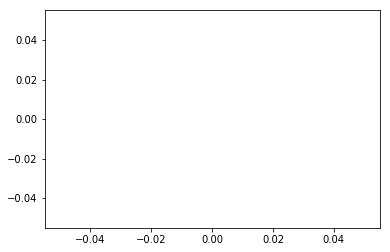

In [65]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)